## Habitat Classification 

Based on the opportunity polygons from MHC and the current LC data predcition

In [1]:
import rasterio
import geopandas as gpd
import numpy as np
import json
import random
from rasterio.mask import mask
from shapely.geometry import Point, Polygon, box
from rasterio.features import rasterize
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [2]:
# 📂 File Paths
raster_path = "../data/tif/SK0858_combined.tif"
shapefile_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"
json_path = "habitat_codes.json"  # Habitat classification file
output_raster_path = "../data/tif/updated_SK0858.tif"

In [3]:
# Set correct CRS (EPSG 27700 - British National Grid)
target_crs = "EPSG:27700"

# Load habitat classification dictionary
with open(json_path, "r") as file:
    habitat_dict = json.load(file)["habitat_codes"]

# Load raster and get CRS
with rasterio.open(raster_path) as src:
    land_cover = src.read(1)  # Read the first band
    profile = src.profile
    raster_bounds = src.bounds
    raster_crs = src.crs  # Get CRS from raster
    transform = src.transform

# Load shapefile
habitats = gpd.read_file(shapefile_path)

# Check if the CRS needs to be fixed
if habitats.crs is None:
    print("⚠ Warning: Shapefile has no CRS! Setting to EPSG:27700.")
    habitats.set_crs(target_crs, inplace=True)
elif habitats.crs != target_crs:
    print(f"⚠ Warning: Shapefile CRS ({habitats.crs}) does not match EPSG:27700. Reprojecting...")
    habitats = habitats.to_crs(target_crs)

# Print dataset summary
print("Raster CRS:", raster_crs)
print("Shapefile CRS:", habitats.crs)
print("Raster unique values:", np.unique(land_cover))
print("Shapefile columns:", habitats.columns)
print("Unique values in 'utopiaphas':", habitats["utopiaphas"].unique())


⚠ Warning: Shapefile CRS (EPSG:3857) does not match EPSG:27700. Reprojecting...
Raster CRS: EPSG:27700
Shapefile CRS: EPSG:27700
Raster unique values: [101 102 103 104 201 202 203 204 302 303 403 404 409 410 411 504]
Shapefile columns: Index(['land_manag', 'mhc_id', 'currentpha', 'utopiaphas', 'notes',
       'interventi', 'interven_1', 'interven_2', 'utopiaukha', 'utopiauk_1',
       'SHAPE__Len', 'SHAPE__Are', 'hectares', 'geometry'],
      dtype='object')
Unique values in 'utopiaphas': ['MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS' 'WOOD PASTURE'
 'BROADLEAVED WOODLAND' 'SPECIES RICH GRASSLAND SCRUB MOSAIC'
 'DRY HEATH WITH SCATTERED SCRUB WOODY MOSAICS'
 'BROADLEAVED WOODLAND SCATTERED SCRUB' 'BROADLEAVED WOODLAND & SCRUB'
 'DRY HEATH' 'WET WOODLAND' 'FLUSH' 'WET HEATH' 'BLANKET BOG'
 'BROADLEAVED/WET WOODLAND' 'CLOUGH WOODLAND' 'ACID GRASSLAND'
 'BLANKET BOG WITH SCATTERED SCRUB WOODY MOSAICS' 'WILLOW SCRUB'
 'ACID GRASSLAND & SCATTERED GORSE SCRUB MOSAIC' 'SCRUB WOODLA

⚠ Warning: Habitat 'DENSE & SCATTERED SCRUB MOSAIC' not found in habitat_codes.json
⚠ Warning: Habitat 'DRY HEATH  & SCRUB MOSAIC' not found in habitat_codes.json
⚠ Warning: Habitat 'MARSHY /ACID /NEUTRAL -MOSAIC SPECIES RICH GRASSLANDS' not found in habitat_codes.json
⚠ Warning: Habitat 'MARSHY /ACID /NEUTRAL  -MOSAIC SPECIES RICH GRASSLANDS   WITH SCATTERED SCRUB WOODY MOSAICS' not found in habitat_codes.json
⚠ Warning: Habitat 'BASE RICH FEN MOSAIC' not found in habitat_codes.json
Raster Bounds: BoundingBox(left=408000.0, bottom=358000.0, right=409000.0, top=359000.0)
Filtered Habitat Bounds: [407619.06876586 357620.67787839 409453.23045198 359696.34746899]


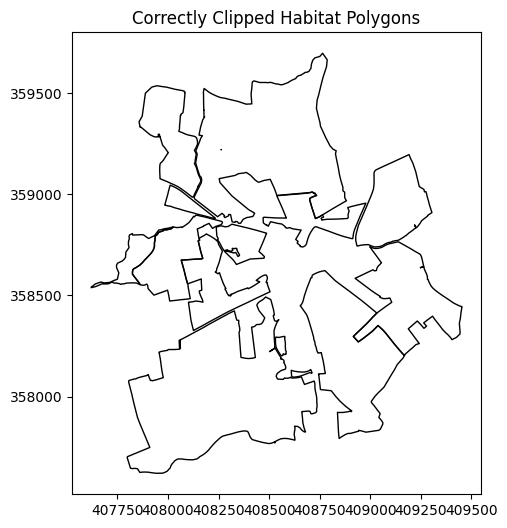

,land_manag,mhc_id,currentpha,utopiaphas,notes,interventi,interven_1,interven_2,utopiaukha,utopiauk_1,SHAPE__Len,SHAPE__Are,hectares,geometry,type,density
1,GAP FARM,4-GF,None,WOOD PASTURE,WOODPASTURE WITH SPECIES RICH GRASSLAND,None,None,None,None,None,3000.468232,1.457258e+05,5.256694,"POLYGON ((408913.337 358779.179, 408905.137 35...",wood_pasture,3
16,PDNPA,None,None,WOOD PASTURE,WOODPASTURE WITH SPECIES RICH GRASSLAND,None,None,None,None,None,1614.072078,8.955411e+04,3.230603,"POLYGON ((408354.842 358697.679, 408353.242 35...",wood_pasture,3
17,PDNPA,None,None,MARSHY /ACID /NEUTRAL -MOSAIC SPECIES RICH GR...,These areas will be subject to a hydrological ...,None,None,None,None,None,1066.536119,4.126628e+04,1.488531,"POLYGON ((408132.541 358904.579, 408132.441 35...",ignore,0
55,Villa Farm,1-VF-A,None,WOOD PASTURE,WOODPASTURE WITH SPECIES RICH GRASSLAND,None,None,None,None,None,7155.340273,1.211792e+06,43.728250,"POLYGON ((407797.453 357701.878, 407910.353 35...",wood_pasture,3
56,Villa Farm,1-VF-B,None,WOOD PASTURE,None,None,None,None,None,None,444.597563,1.053029e+04,0.379954,"POLYGON ((408583.445 358224.279, 408583.946 35...",wood_pasture,3


In [4]:
# Normalize & Classify 
def classify_habitat(row):
    habitat_name = str(row["utopiaphas"]).strip().upper()  # Normalize text
    
    # Fix common typos in names (e.g., MOSIAC → MOSAIC)
    habitat_name = habitat_name.replace("MOSIAC", "MOSAIC")

    # If habitat is missing, default to ("ignore", 0)
    if habitat_name not in habitat_dict:
        print(f"⚠ Warning: Habitat '{habitat_name}' not found in habitat_codes.json")
        return "ignore", 0
    
    return habitat_dict[habitat_name]["type"], habitat_dict[habitat_name]["density"]

# Apply classification
habitats[["type", "density"]] = habitats.apply(classify_habitat, axis=1, result_type="expand")

# Create a bounding box from the raster bounds
raster_bbox = box(*raster_bounds)

# Clip the habitat polygons to exactly fit the raster extent
habitats_filtered = habitats[habitats.intersects(raster_bbox)]

# Debug: Check new bounds
print(f"Raster Bounds: {raster_bounds}")
print(f"Filtered Habitat Bounds: {habitats_filtered.total_bounds}")

# Plot clipped habitat to verify
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
habitats_filtered.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
ax.set_title("Correctly Clipped Habitat Polygons")
plt.show()

# Display a preview
habitats_filtered.head()

In [5]:
# Generate scrub patches
def generate_scrub_patches(polygon, density, patch_size_range=(5, 50)):
    """Generate scrub patches inside a polygon"""
    num_patches = int(density * 2)
    minx, miny, maxx, maxy = polygon.bounds
    patches = []

    for _ in range(num_patches):
        patch_size = random.randint(*patch_size_range)
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            buffer_size = np.sqrt(patch_size) * 0.5
            patch = point.buffer(buffer_size)
            patches.append(patch)

    return patches

# Generate scrub patches
scrub_patches = []
for _, row in habitats_filtered[habitats_filtered["type"] == "scrub"].iterrows():
    patches = generate_scrub_patches(row.geometry, row["density"])
    scrub_patches.extend(patches)

# Rasterize scrub patches
scrub_raster = rasterize(
    [(patch, 103) for patch in scrub_patches], 
    out_shape=land_cover.shape, 
    transform=profile["transform"]
)

# Apply scrub patches to raster (only add scrub where empty)
land_cover[(scrub_raster == 103) & (land_cover == 0)] = 103

print("Scrub patches generated and added to raster.")


Scrub patches generated and added to raster.


In [6]:
# Allow converting a wider range of land cover types
valid_conversion_classes = [302, 303]  # Only convert grasslands
overwrite_classes = [202, 204]  # Also allow upland grass moor & mosaic to be converted

# Function to generate tree crowns as clusters (not just single pixels)
def generate_wood_pasture_trees(polygon, density):
    """Generate tree crown clusters inside wood pasture polygons"""
    num_trees = int(density * 35)  # Increase number of trees per area
    minx, miny, maxx, maxy = polygon.bounds
    tree_patches = []

    for _ in range(num_trees):
        x, y = np.random.uniform(minx, maxx), np.random.uniform(miny, maxy)
        point = Point(x, y)

        if polygon.contains(point):
            tree_cluster = point.buffer(6.25)  # Approximate a ~100m² tree crown (radius 6.25m)
            tree_patches.append(tree_cluster)

    return tree_patches

# Generate tree crowns for wood pasture polygons
wood_pasture_patches = []
for _, row in habitats_filtered[habitats_filtered["type"] == "wood_pasture"].iterrows():
    tree_clusters = generate_wood_pasture_trees(row.geometry, row["density"])
    wood_pasture_patches.extend(tree_clusters)

# Rasterize tree crown patches
wood_pasture_raster = rasterize(
    [(patch, 101) for patch in wood_pasture_patches], 
    out_shape=land_cover.shape, 
    transform=profile["transform"]
)

# Convert more land cover types to trees
valid_conversion_classes = [302, 303, 202, 204]  # Grasslands + Upland + Mosaic
for code in valid_conversion_classes:
    land_cover[(wood_pasture_raster == 101) & (land_cover == code)] = 101

print("Larger tree crowns added in wood pasture areas!")


Larger tree crowns added in wood pasture areas!


In [7]:
# Save the updated raster
with rasterio.open(output_raster_path, "w", **profile) as dst:
    dst.write(land_cover, 1)

print(f"Updated raster saved: {output_raster_path}")

Updated raster saved: ../data/tif/updated_SK0858.tif


# Plot the data

In [8]:
# File paths
original_pred_path = "../data/tif/SK0858_combined.tif"
raw_imagery_path = "../data/tif/SK0858.tif"
updated_habitat_path = "../data/tif/updated_SK0858.tif"

In [9]:
# Function to load raster data
def load_raster(filepath, rgb=False):
    with rasterio.open(filepath) as src:
        if rgb:
            return src.read([1, 2, 3]).transpose(1, 2, 0)  # Load RGB as (H, W, 3)
        return src.read(1)  # Load single-band raster

# Load rasters
original_pred = load_raster(original_pred_path)
raw_imagery = load_raster(raw_imagery_path, rgb=True)  # Load as RGB
updated_habitat = load_raster(updated_habitat_path)

# Load raster metadata to define clipping area
with rasterio.open(updated_habitat_path) as src:
    raster_bounds = src.bounds  # Get raster extent

# Clip the shapefile to the raster bounds
habitats_filtered = habitats.cx[raster_bounds.left:raster_bounds.right, raster_bounds.bottom:raster_bounds.top]

# Print raster and shapefile info
print(f"Original Predictions Shape: {original_pred.shape}")
print(f"Raw Imagery Shape (RGB): {raw_imagery.shape}")
print(f"Updated Habitat Shape: {updated_habitat.shape}")
print(f"Clipped Shapefile CRS: {habitats_filtered.crs}, Number of Features: {len(habitats_filtered)}")


Original Predictions Shape: (8000, 8000)
Raw Imagery Shape (RGB): (8000, 8000, 3)
Updated Habitat Shape: (8000, 8000)
Clipped Shapefile CRS: EPSG:27700, Number of Features: 14


In [10]:
# Land cover color mapping
class_colors_combined = {
    0: '#D3D3D3',  # No Class (Light grey)
    101: '#006400',  # Broadleaved Woodland (Dark green)
    102: '#008000',  # Coniferous Woodland (Green)
    103: '#808000',  # Scrub (Olive)
    104: '#A52A2A',  # Felled/Young Trees (Brown)
    201: '#800080',  # Heather Moorland (Purple)
    202: '#DDA0DD',  # Upland Grass Moor (Plum)
    203: '#FFFF00',  # Bracken (Yellow)
    204: '#FFD700',  # Mosaic (Gold)
    504: '#FF0000',  # Rush Pasture (Red)
    302: '#90EE90',  # Improved Grassland (Light green)
    303: '#32CD32',  # Rough Grassland (Lime green)
    401: '#0000FF',  # River (Blue)
    402: '#00FFFF',  # Lake (Cyan)
    403: '#ADD8E6',  # Pond (Light blue)
    404: '#808080',  # Suburban (Grey)
    405: '#808080',  # Cemeteries (Grey)
    406: '#90EE90',  # Playing Fields (Light green)
    407: '#000000',  # Railway Verges (Black)
    408: '#000000',  # Railway (Black)
    409: '#000000',  # Road (Black)
    410: '#808080',  # Road Verges (Grey)
    411: '#000000',  # Dense Urban (Black)
    205: '#FF00FF',  # Heather Moorland on blanket bog/deep peat (Magenta)
    206: '#FF1493',  # Upland Grass Moor on blanket bog/deep peat (Deep pink)
    207: '#FF69B4'   # Mosaic on blanket bog/deep peat (Hot pink)
}

# Convert hex colors to RGB (0-1 range for matplotlib)
land_cover_cmap = mcolors.ListedColormap([mcolors.hex2color(class_colors_combined[val]) for val in sorted(class_colors_combined.keys())])
land_cover_norm = mcolors.BoundaryNorm(sorted(class_colors_combined.keys()), land_cover_cmap.N)


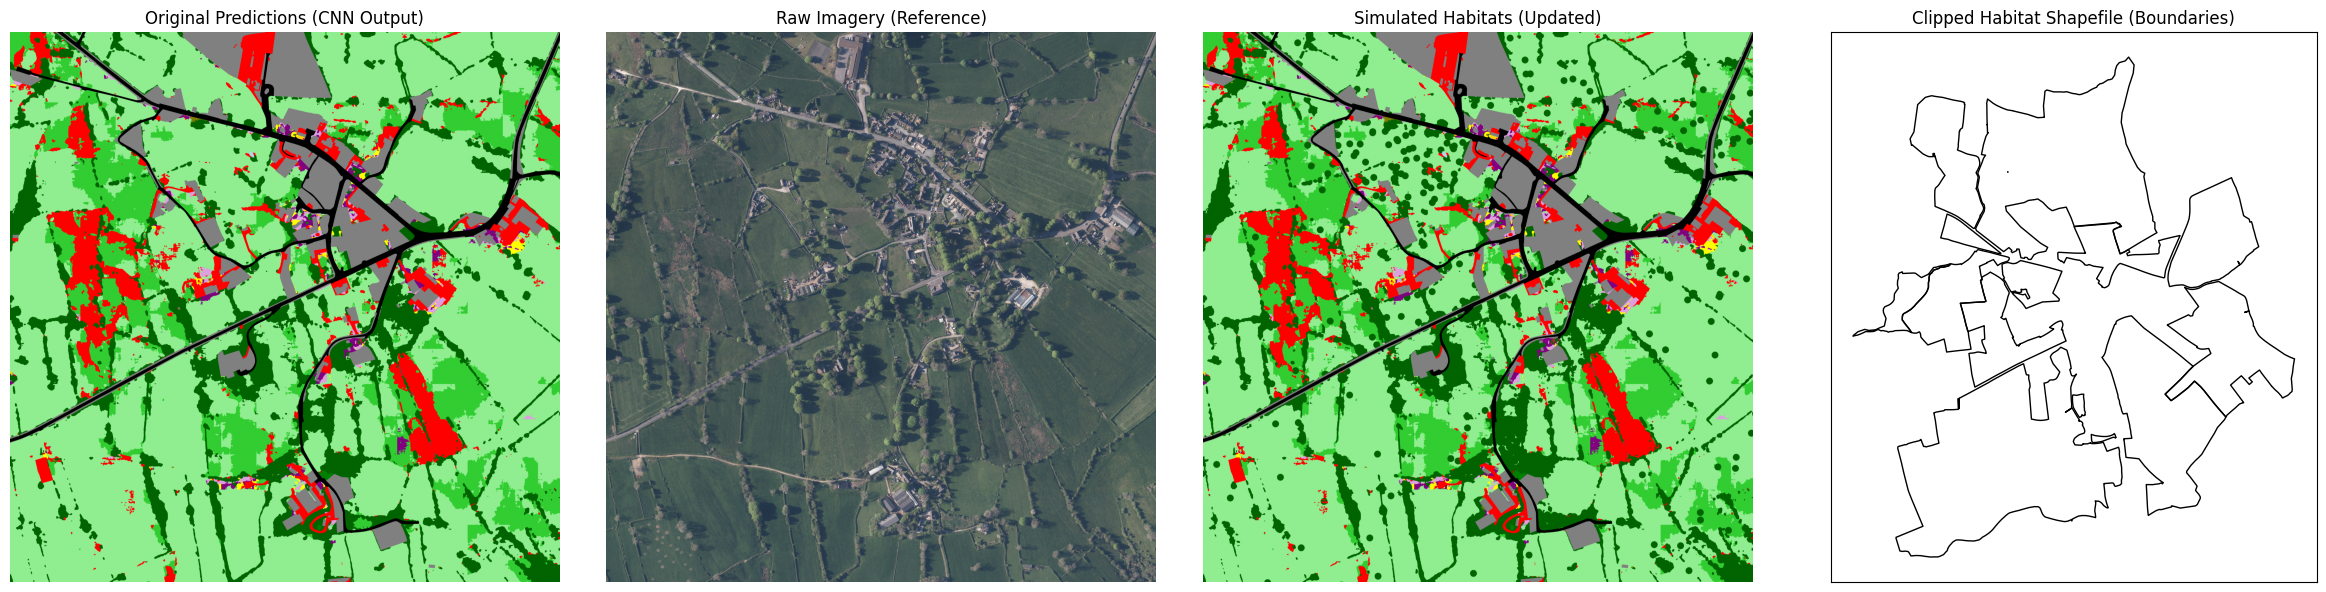

In [11]:
# Define figure size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot Original Predictions (Land Cover)
im1 = axes[0].imshow(original_pred, cmap=land_cover_cmap, norm=land_cover_norm)
axes[0].set_title("Original Predictions (CNN Output)")
axes[0].axis("off")

# Plot Raw Imagery (Center) as RGB
axes[1].imshow(raw_imagery)
axes[1].set_title("Raw Imagery (Reference)")
axes[1].axis("off")

# Plot Updated Habitat Map (Simulated Changes)
im3 = axes[2].imshow(updated_habitat, cmap=land_cover_cmap, norm=land_cover_norm)
axes[2].set_title("Simulated Habitats (Updated)")
axes[2].axis("off")

# Plot Clipped Habitat Shapefile
habitats_filtered.plot(ax=axes[3], edgecolor="black", facecolor="none", linewidth=1)
axes[3].set_title("Clipped Habitat Shapefile (Boundaries)")
axes[3].set_xticks([])
axes[3].set_yticks([])

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

# Check if any new 103 (Scrub) or 101 (Trees) pixels were added
scrub_diff = np.sum(updated_habitat == 103) - np.sum(original_pred == 103)
wood_pasture_diff = np.sum(updated_habitat == 101) - np.sum(original_pred == 101)

print(f"New Scrub Pixels Added: {scrub_diff}")
print(f"New Wood Pasture Pixels Added: {wood_pasture_diff}")

# If both values are 0, then no new patches were actually added!


New Scrub Pixels Added: 0
New Wood Pasture Pixels Added: 1335484
